<hr size="5" />

### **<font color='DarkCyan'>Salzburg University of Applied Sciences - 2023**  
#### **<font color='DarkCyan'>Information Technology & Systems Engineering**

# **<font color='GoldenRod'>Master Thesis**  
## **<font color='GoldenRod'>Deep Learning for Advancing Animal Breeding: A Study on Austrian Fleckvieh Cattle**

<hr size="5">

#### Student Name: Jakob Ganitzer
#### Degree Program:  ITSM-B

<hr size="5" />

### Imports

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from models.hyenaEncoder import HyenaRegressor_MLP_cat_Reduced
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import pearsonr
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
from sklearn.metrics import mean_squared_error 
from utils.tokenizer import CharacterTokenizer
from utils.genomicDataset import GenomicDataset2
import cairosvg
from matplotlib.colors import Normalize

In [3]:
def memory_stats():
    print(torch.cuda.memory_allocated()/1024**2)
    print(torch.cuda.memory_cached()/1024**2)

In [4]:
#Hyena Config
#Config

#HyenaOperator
order = 2 
activation = 'relu'

#max_pos = 35000
max_pos = 27000

batch_size = 64 #128 

input_dim = 8#3
num_layers = 6
num_heads = 1

hidden1 = 1000
hidden2 = 500

In [5]:
def initHyena(order, activation, max_pos, batch_size, input_dim, num_layers, num_heads, hidden1, hidden2):
    order = order
    activation = activation
    max_pos = max_pos
    batch_size = batch_size
    input_dim = input_dim
    num_layers = num_layers
    num_heads = num_heads
    hidden1 = hidden1
    hidden2 = hidden2

In [6]:
criterion = nn.MSELoss()

### Load Data

In [7]:
dataRoot = "/data"
eval_dataframes = '/eval_dataframes/hyena/'

In [8]:
heritability = "/h40"
phenotype_path = dataRoot + heritability + heritability + "_simu.dat"
snp_path = dataRoot + heritability + heritability + "_simu.snp"
benchmark_path = dataRoot + heritability + heritability + "_simu.bv"
pedigree_path = dataRoot + heritability + heritability + "_simu.ped"
snpPos_path = dataRoot + heritability + heritability + "_simu_snp.txt"
qtl_path = dataRoot + heritability + heritability + "_simu_qtl.txt"

In [9]:
checkpointRoot = '/data/checkpoints/'

In [10]:
df_dam30F = pd.read_parquet(dataRoot + heritability + '/dam30F.parquet', engine='pyarrow')

In [11]:
modelName = 'MLP_Hyena'

In [13]:
heritability = "/h40"

X_path = "/test/snp_X_test_01_maf_one_hot.parquet"

y_path = "/test/snp_y_test_01_maf_one_hot.parquet"

#gen30

X_path = "/test/snpGen30_X_test_01.parquet"

y_path = "/test/snpGen30_y_test_01.parquet"

In [14]:
#Hyena
heritability = "/h40"
X_path = "/test/snp_X_test_01_maf.parquet"

y_path = "/test/snp_y_test_01_maf.parquet"

#gen30
trainPath = '/snp_pheno_BPpos_maf.parquet'
testPath = '/snpTruePheno_gen30_BPpos_maf.parquet'

In [15]:
# Pretrained

test_file_path = dataRoot + heritability + '/test/snp_X_test_maf_fine_token.txt'
test_label_path = dataRoot + heritability + '/test/snp_y_test_maf_fine_token.parquet'

#maf
preTrainedPath = "/data/checkpoints/Hyena_MLM_v10_fine_L6_maf_20230913-224450/" + "best_model_state_dict.pth"

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

In [17]:
def add_value(x, value):
    return x + value

class CatTestLoaderFine:
    def __init__(self, dataRoot, trainPath, testPath,wandbDir, batch_size = 16):
        self.dataRoot = dataRoot
        self.trainPath = trainPath
        self.testPath = testPath
        self.batch_size = batch_size
        self.wandbDir = wandbDir

    def getLoaders(self, addValue = 0):
        df_snp_pheno_train = pd.read_parquet(self.dataRoot + self.trainPath, engine='pyarrow')
        df_snp_pheno_test = pd.read_parquet(self.dataRoot + self.testPath, engine='pyarrow')

        X_train_df = df_snp_pheno_train.drop(columns=['phenotype', 'id'], axis=1)
        y_train = df_snp_pheno_train["phenotype"]
        
        X_val_df = df_snp_pheno_test.drop(columns=['phenotype', 'id'], axis=1)
        y_val = df_snp_pheno_test["phenotype"]
        
        id_val = df_snp_pheno_test["id"]
        id_train = df_snp_pheno_train["id"]
        
        X_val_df = X_val_df.apply(add_value, value=addValue)
        X_train_df = X_train_df.apply(add_value, value=addValue)
      
        X_val_tensor = torch.tensor(X_val_df.to_numpy(), dtype=torch.int).to('cpu')
        y_val_tensor = torch.tensor(y_val.values, dtype=torch.float).to('cpu')
        X_train_tensor = torch.tensor(X_train_df.to_numpy(), dtype=torch.int).to('cpu')
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float).to('cpu')
        
        id_val_tensor = torch.tensor(id_val.values, dtype=torch.int).to('cpu')
        id_train_tensor = torch.tensor(id_train.values, dtype=torch.int).to('cpu')
        
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor, id_train_tensor)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor, id_val_tensor)

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, pin_memory = True, num_workers = 2)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False, pin_memory = True, num_workers = 2)

        return val_loader, train_loader

class CatTestLoaderCLSFine:
    def __init__(self, test_file_path, test_label_path, batch_size = 16, val_size = 0.2, model_max_length = -1):
        self.test_file_path = test_file_path
        self.test_label_path = test_label_path
        self.batch_size = batch_size
        self.val_size = val_size
        self.model_max_length = model_max_length

    def getLoaders(self):
        
        tokenizer = CharacterTokenizer(
            characters=['0', '1', '2'],  # add SNP characters, 
            model_max_length= self.model_max_length,
            add_special_tokens=True, 
            padding_side='right',
            return_special_tokens_mask=False    
        )

        val_dataset = GenomicDataset2(file_path = self.test_file_path, label_path = self.test_label_path, max_length = self.model_max_length, tokenizer = tokenizer, use_padding = False)        

        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False, pin_memory = True)

        return val_loader

    
class OneHotTestLoaderFine:
    def __init__(self, dataRoot,trainPath, testPath,wandbDir, batch_size = 16):
        self.dataRoot = dataRoot
        self.trainPath = trainPath
        self.testPath = testPath
        self.batch_size = batch_size
        self.wandbDir = wandbDir
        
    def getLoaders(self):

        df_snp_pheno_train = pd.read_parquet(self.dataRoot + self.trainPath, engine='pyarrow')
        df_snp_pheno_test = pd.read_parquet(self.dataRoot + self.testPath, engine='pyarrow')

        X_train_df = df_snp_pheno_train.drop(columns=['phenotype', 'id'], axis=1)
        X_val_df = df_snp_pheno_test.drop(columns=['phenotype', 'id', 'sire', 'dam'], axis=1)
        y_train = df_snp_pheno_train["phenotype"]
        y_val = df_snp_pheno_test["phenotype"]
        
        id_val = df_snp_pheno_test["id"]
        id_train = df_snp_pheno_train["id"]
        
        X_train = X_train_df.to_numpy()
        X_val = X_val_df.to_numpy()

        # Reshape the data back to its original shape
        X_train = X_train.reshape(X_train_df.shape[0], int(X_train_df.shape[1]/3), 3)
        X_val = X_val.reshape(X_val_df.shape[0], int(X_val_df.shape[1]/3), 3)
        
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to('cpu')
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to('cpu')

        y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).to('cpu')
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to('cpu')

        id_val_tensor = torch.tensor(id_val.values, dtype=torch.int).to('cpu')
        id_train_tensor = torch.tensor(id_train.values, dtype=torch.int).to('cpu')
        
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor, id_train_tensor)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor, id_val_tensor)

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, pin_memory = True,num_workers = 2)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False, pin_memory = True, num_workers = 2)

        return val_loader, train_loader    

In [18]:
def loadAndCheckModel():
    # Load the saved checkpoint
    checkpoint = torch.load(checkpointRoot + modelName + '/best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

In [19]:
def evaluatePretrained():
    inference_df = pd.DataFrame(columns=['targets', 'output'])
    dtype1 = torch.cuda.IntTensor
    dtype2 = torch.cuda.FloatTensor

    dfs = []

    with torch.no_grad():
        for data, targets in val_loader:
            with torch.cuda.amp.autocast():
                data = data.to(device).type(dtype1)
                targets = targets.squeeze().to(device).type(dtype2)

                output, pooled_output, embedding = model(data)

                targets_np = targets.cpu().numpy()
                output_np = output.cpu().numpy().astype('float32')

                temp_df = pd.DataFrame({
                    'targets': targets_np,
                    'output': output_np
                })

                inference_df = pd.concat([inference_df, temp_df], ignore_index=True)

                pooled_output_np = pooled_output.cpu().numpy().astype('float32')

                temp_df = pd.DataFrame(pooled_output_np, columns=[f'snp_{i}' for i in range(pooled_output_np.shape[1])])

                dfs.append(temp_df)

    df_pooled_output = pd.concat(dfs, ignore_index=True, axis=0)
    targets = torch.tensor(inference_df['targets'].values).to(device)
    output = torch.tensor(inference_df['output'].values).to(device)
    
    return inference_df, output, targets, df_pooled_output

def evaluate():
    inference_df = pd.DataFrame(columns=['targets', 'output'])
    dtype1 = torch.cuda.IntTensor
    dtype2 = torch.cuda.FloatTensor

    dfs = []

    with torch.no_grad():
        for data, targets, ids in val_loader:
            with torch.cuda.amp.autocast():
                data = data.to(device).type(dtype1)
                targets = targets.squeeze().to(device).type(dtype2)
                ids = ids.to(device).type(dtype1)

                output, pooled_output, embedding = model(data)
                
                targets_np = targets.cpu().numpy()
                output_np = output.cpu().numpy().astype('float32')
                ids_np = ids.cpu().numpy().astype('int')

                temp_df = pd.DataFrame({
                    'targets': targets_np,
                    'output': output_np,
                    'id': ids_np
                })

                inference_df = pd.concat([inference_df, temp_df], ignore_index=True)

                pooled_output_np = pooled_output.cpu().numpy().astype('float32')

                temp_df = pd.DataFrame(pooled_output_np, columns=[f'snp_{i}' for i in range(pooled_output_np.shape[1])])

                dfs.append(temp_df)

    df_pooled_output = pd.concat(dfs, ignore_index=True, axis=0)
    targets = torch.tensor(inference_df['targets'].values).to(device)
    output = torch.tensor(inference_df['output'].values).to(device)
    
    return inference_df, output, targets, df_pooled_output

def evaluateOneHot():
    inference_df = pd.DataFrame(columns=['targets', 'output'])

    dtype = torch.cuda.FloatTensor

    dfs = []

    with torch.no_grad():
        for data, targets, ids in val_loader:
            with torch.cuda.amp.autocast():
                data = data.to(device).type(dtype)
                targets = targets.squeeze().to(device).type(dtype)
                ids = ids.to(device).type(dtype)

                output, pooled_output, embedding = model(data)

                targets_np = targets.cpu().numpy()
                output_np = output.cpu().numpy().astype('float32')
                ids_np = ids.cpu().numpy().astype('int')

                temp_df = pd.DataFrame({
                    'targets': targets_np,
                    'output': output_np,
                    'id': ids_np
                })

                inference_df = pd.concat([inference_df, temp_df], ignore_index=True)

                pooled_output_np = pooled_output.cpu().numpy().astype('float32')

                temp_df = pd.DataFrame(pooled_output_np, columns=[f'snp_{i}' for i in range(pooled_output_np.shape[1])])

                dfs.append(temp_df)

    df_pooled_output = pd.concat(dfs, ignore_index=True, axis=0)
    targets = torch.tensor(inference_df['targets'].values).to(device)
    output = torch.tensor(inference_df['output'].values).to(device)
    
    return inference_df, output, targets, df_pooled_output

In [20]:
def createDataframeAndSave(inference_df, df_pooled_output, hasId = True):
    combined_df = pd.concat([inference_df, df_pooled_output], axis=1)
    if hasId == True : combined_df['id'] = combined_df['id'].astype(int)
    combined_df.to_parquet(dataRoot + heritability + eval_dataframes + modelName + '.parquet')

In [22]:
def calcMetrics(output, targets):
    mse = mean_squared_error(targets, output)
    mae = mean_absolute_error(targets, output)
    r2 = r2_score(targets, output)
    _pearsonr, _pvalue = pearsonr(targets, output)

    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((targets- output) / targets)) * 100
    mbe = np.mean(targets - output)
    
    print("MSE:", mse)
    print("Mean Absolute Error:", mae)
    print("R2 Score:", r2)
    print("Pearson Correlation Coefficient:", _pearsonr)
    print("p-value:", _pvalue)
    print("rmse:", rmse)
    print("mape:", mape)
    print("mbe:", mbe)

In [23]:
data = ['ModelName','MSE', 'MAE', 'R2', 'PearsonR']
df_metrics = pd.DataFrame(columns = data)

def calcMetricsStore(output, targets, modelName):
    mse = mean_squared_error(targets, output)
    mae = mean_absolute_error(targets, output)
    r2 = r2_score(targets, output)
    _pearsonr, _pvalue = pearsonr(targets, output)

    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((targets - output) / targets)) * 100
    mbe = np.mean(targets - output)

    new_data = {
        'ModelName': modelName,
        'MSE': mse,
        'MAE': mae,
        'R2': r2,
        'PearsonR': _pearsonr,
    }

    df = pd.DataFrame([new_data])

    return df

In [26]:
def stratifiedMetrics(output, targets, num_bins=3):
    # Determine bin edges
    bin_edges = np.linspace(min(targets), max(targets), num_bins+1)
    
    for i in range(num_bins):
        # Select data within the bin
        mask = (targets >= bin_edges[i]) & (targets < bin_edges[i+1])
        targets_bin = targets[mask]
        output_bin = output[mask]
        
        # Print value range of the bin
        bin_range = f"{bin_edges[i]} - {bin_edges[i+1]}"
        print(f"\nValue Range for Bin {i+1}: {bin_range}")

        mae = mean_absolute_error(targets_bin, output_bin)
        
        print("Mean Absolute Error:", mae)

In [27]:
def createScatterPlot(inference_df, imageName):
    # Show correlation between phenotypes

    fig, ax = plt.subplots(figsize=(5, 5))  

    # Add trendline
    sns.regplot(data=inference_df, x="output", y="targets", ax=ax, color='darkblue',line_kws={"color": "red"}, scatter = True, scatter_kws={'s':3, 'rasterized': True})

    # Calculate slope and intercept
    slope, intercept = np.polyfit(inference_df["output"], inference_df["targets"], 1)
    line = f"TBV = {intercept:.4f} + {slope:.4f} x EBV"  # Equation of the line

    # Plot slope and intercept
    ax.text(0.05, 0.90, line, transform=ax.transAxes, va="top", fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    ax.axline((9.8, 9.8), slope=1, color='black', linestyle='--') 
    # Set axis labels
    
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlabel("EBV", fontsize=12)
    ax.set_ylabel("TBV", fontsize=12)

    ax.set_xlim(9.5, 16.5)
    ax.set_ylim(9.5, 16.5)
    
    plt.savefig('images/corr_' + imageName + '.png')
    plt.savefig('images/corr_' + imageName + '.svg', format='svg', dpi=300)
    cairosvg.svg2pdf(url='images/corr_' + imageName + '.svg', write_to='images/corr_' + imageName + '.pdf')
    plt.savefig('images/corr_' + imageName + '.eps', format='eps')
    
    plt.show() 

In [28]:
def loadEvalData(modelName):
    model_data = pd.read_parquet(dataRoot + heritability + eval_dataframes + modelName + '.parquet', engine='pyarrow')
    
    output_data = model_data['output'].values.astype(float)
    target_data = model_data['targets'].values.astype(float)

    output = torch.Tensor(output_data)
    targets = torch.Tensor(target_data)
    return model_data[['output', 'targets']],output_data, target_data, model_data

In [29]:
sns.set_style("darkgrid")
sns.set_context("paper")

def plot_histograms(output, targets, imageName):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    sns.histplot(output, ax=axs[0], kde=True)
    sns.histplot(targets, ax=axs[1], color='mediumseagreen', kde=True)

    # Calculate mean and standard deviation
    output_mean = np.mean(output)
    output_std = np.std(output)
    targets_mean = np.mean(targets)
    targets_std = np.std(targets)

    # Add mean and standard deviation as text annotations
    axs[0].text(0.05, 0.9, f'Mean: {output_mean:.2f}\nSD: {output_std:.2f}', transform=axs[0].transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    axs[1].text(0.05, 0.9, f'Mean: {targets_mean:.2f}\nSD: {targets_std:.2f}', transform=axs[1].transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    # Add lines for mean
    axs[0].axvline(output_mean, color='red', linestyle='dashed', linewidth=1)
    axs[1].axvline(targets_mean, color='red', linestyle='dashed', linewidth=1)

    sns.histplot(output, ax=axs[2],  kde=True, label='EBV', element='step')
    sns.histplot(targets, ax=axs[2], color='mediumseagreen', kde=True, label='TBV', element='step')

    # Add labels and titles
    axs[0].tick_params(axis='both', which='major', labelsize=12) 
    axs[0].set_xlabel('Estimated Breeding Values', fontsize=14) 
    axs[0].set_ylabel('Count', fontsize=14)
    axs[0].set_title('EBV Distribution', fontsize=16)  

    axs[1].tick_params(axis='both', which='major', labelsize=12) 
    axs[1].set_xlabel('True Breeding Values', fontsize=14)
    axs[1].set_ylabel('Count', fontsize=14)
    axs[1].set_title('TBV Distribution', fontsize=16)

    axs[2].tick_params(axis='both', which='major', labelsize=12) 
    axs[2].set_xlabel('Values', fontsize=14)
    axs[2].set_ylabel('Count', fontsize=14)
    axs[2].set_title('Overlayed EBV and TBV Distributions', fontsize=16)

    axs[2].legend()

    plt.tight_layout()
    plt.savefig('images/dist_' + imageName + '.png')
    plt.savefig('images/dist_' + imageName + '.svg', format='svg', dpi=300)
    cairosvg.svg2pdf(url='images/dist_' + imageName + '.svg', write_to='images/dist_' + imageName + '.pdf')
    plt.savefig('images/dist_' + imageName + '.eps', format='eps')
    plt.show()


In [30]:
def plot_residuals(output_np, targets_np, imageName):
    # Calculate residuals
    residuals = targets_np - output_np

    fig, ax = plt.subplots(figsize=(5,4))

    sns.regplot(x=output_np, y=residuals, scatter=True, ax=ax, line_kws=dict(color="r"), color='darkblue', scatter_kws={'s':3, 'rasterized': True})

    ax.axhline(y=0, color='black', linestyle='--') 
    ax.tick_params(axis='both', which='major', labelsize=10) 
    ax.set_xlabel('EBV', fontsize=12)
    ax.set_ylabel('Residuals',  fontsize=12)

    ax.set_xlim(9.5, 16.5) 
    ax.set_ylim(-1.7, 1.7) 
    
    plt.tight_layout()
    
    plt.savefig('images/resid_' + imageName + '.png')
    plt.savefig('images/resid_' + imageName + '.svg', format='svg', dpi=300)
    cairosvg.svg2pdf(url='images/resid_' + imageName + '.svg', write_to='images/resid_' + imageName + '.pdf')
    plt.savefig('images/resid_' + imageName + '.eps', format='eps')
    plt.show()

In [31]:
import scipy.stats
# Define Bootstrapping Function for a Metric
def bootstrap_metric(metric_func, output, targets, num_iterations=1000):
    metric_values = []
    for _ in range(num_iterations):
        # Resample with replacement
        indices = np.random.choice(len(output), len(output), replace=True)
        resampled_output = output[indices]
        resampled_targets = targets[indices]
        
        # Calculate the metric on the resampled data
        metric = metric_func(resampled_targets, resampled_output)
        metric_values.append(metric)
    
    m, se = np.mean(metric_values), scipy.stats.sem(metric_values)
    return metric_values, m, se

# Function to Calculate Metrics
def calcMetrics2(output, targets):
    mse = mean_squared_error(targets, output)
    mae = mean_absolute_error(targets, output)
    r2 = r2_score(targets, output)
    pearsonr_value, _ = pearsonr(targets, output)
    
    # Calculate error bars using bootstrapping
    mse_errors, mse_mean, mse_se = bootstrap_metric(mean_squared_error, output, targets)
    mae_errors, mae_mean, mae_se = bootstrap_metric(mean_absolute_error, output, targets)
    r2_errors, r2_mean, r2_se = bootstrap_metric(r2_score, output, targets)
    pearsonr_errors, pearsonr_mean, pearsonr_se = bootstrap_metric(lambda x, y: pearsonr(x, y)[0], output, targets)
        
    return mse, mse_errors, mse_mean, mse_se, mae, mae_errors, mae_mean, mae_se, r2, r2_errors, r2_mean, r2_se, pearsonr_value, pearsonr_errors, pearsonr_mean, pearsonr_se


In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import UnivariateSpline
import matplotlib.ticker as ticker


def plot_wandering_schemantic(output_np, targets_np):
    sns.set(style="dark")
    sns.set_context("paper")

    residuals = targets_np - output_np
    y_values = residuals
    x_values = output_np

    n_samples = len(x_values)

    quantiles = np.power(2, -np.arange(2, np.floor(np.log(n_samples/10)/np.log(2))+1))
    quantiles = np.concatenate((np.flip(quantiles), np.array([1/2]), 1- quantiles))
    n_bins = len(quantiles) + 1
    bins = pd.cut(x_values, np.quantile(x_values, np.concatenate(([0],  quantiles, [1]))), duplicates='drop')

    x_series = pd.Series(x_values)
    bin_medians = x_series.groupby(bins).median()
    bin_counts  = x_series.groupby(bins).size()
    max_bin_count = bin_counts.max()
    x_range = np.ptp(x_series)

    fig, ax = plt.subplots(figsize=(5, 4)) 
    sns.regplot(x=output_np, y=residuals, scatter=True, ax=ax, line_kws=dict(color="r"), color='darkblue', scatter_kws={'s':3, 'rasterized': True})

    ax.axhline(y=0, color='black', linestyle='--')  

    # Store median, 1st, 5th, 25th, 75th, 95th, and 99th percentile positions for connecting lines
    median_positions = []
    q1_positions = []
    q5_positions = []
    q25_positions = []
    q75_positions = []
    q95_positions = []
    q99_positions = []
    q50_positions = []

    # Calculate the positions for boxplots based on bin medians
    for i, median in enumerate(bin_medians):
        # Get the y_values within the current bin
        current_bin_y = y_values[bins.codes == i]
        print()
        # Calculate the position for the boxplot based on the bin median
        boxplot_position = median
        median_positions.append(boxplot_position)

        # Calculate percentiles if the bin is not empty
        if len(current_bin_y) > 0:
            q1_positions.append(np.percentile(current_bin_y, 1))
            q5_positions.append(np.percentile(current_bin_y, 5))
            q25_positions.append(np.percentile(current_bin_y, 25))
            q75_positions.append(np.percentile(current_bin_y, 75))
            q95_positions.append(np.percentile(current_bin_y, 95))
            q99_positions.append(np.percentile(current_bin_y, 99))
            q50_positions.append(np.percentile(current_bin_y, 50))
        else:
            q1_positions.append(np.nan)
            q5_positions.append(np.nan)
            q25_positions.append(np.nan)
            q75_positions.append(np.nan)
            q95_positions.append(np.nan)
            q99_positions.append(np.nan)
            q50_positions.append(np.nan)

    coolwarm = plt.cm.viridis

    # Plot lines connecting the percentiles using coolwarm colors
    plt.plot(median_positions, q99_positions, color=coolwarm(0.95),linewidth=1.5, label='99% Percentile')  # 95% into the colormap
    plt.plot(median_positions, q95_positions, color=coolwarm(0.85),linewidth=1.5, label='95% Percentile')  # 85% into the colormap
    plt.plot(median_positions, q75_positions, color=coolwarm(0.65),linewidth=1.5, label='75% Quantile')  # 65% into the colormap
    plt.plot(median_positions, q50_positions, color=coolwarm(0.5), linewidth=1.5,label='Median')  # 50% into the colormap
    plt.plot(median_positions, q25_positions, color=coolwarm(0.5), linewidth=1.5,label='25% Quantile')  # 50% into the colormap
    plt.plot(median_positions, q5_positions, color=coolwarm(0.35), linewidth=1.5,label='5% Percentile')  # 35% into the colormap
    plt.plot(median_positions, q1_positions, color=coolwarm(0.15), linewidth=1.5, label='1% Percentile')  # 15% into the colormap

    intervals = bin_medians.index

    unique_values = set() 

    for interval in intervals:
        unique_values.add(interval.left)
        unique_values.add(interval.right)

    unique_values_array = np.array(list(unique_values)) 

    # Loop through unique values and plot vertical lines
    for value in unique_values_array:
        plt.axvline(x=value,  linewidth=1, color='gray', alpha=0.7) 

    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 0.98), ncol=3, title=None, frameon=False, fontsize='9')

    ax.tick_params(axis='both', which='major', labelsize=10) 
    ax.set_xlabel('EBV', fontsize=12)
    ax.set_ylabel('Residuals',  fontsize=12)


    # Remove vertical axis and customize horizontal grid
    sns.despine(left=True)
    plt.grid(axis='y') 
    plt.tight_layout()

    plt.savefig('images/wsp_' + imageName + '.png')
    plt.savefig('images/wsp_' + imageName + '.svg', format='svg', dpi=300)
    cairosvg.svg2pdf(url='images/wsp_' + imageName + '.svg', write_to='images/wsp_' + imageName + '.pdf')
    plt.savefig('images/wsp_' + imageName + '.eps', format='eps')
    plt.show()

## HYENA Inference

In [37]:
#LinRed
modelName = 'MLP_Hyena' 

In [34]:
trainPath = '/snp_pheno_BPpos_maf.parquet'
testPath = '/snpTruePheno_gen30_BPpos_maf.parquet'

catLoader = CatTestLoaderFine(dataRoot + heritability,trainPath, testPath, wandbDir=wandbDir, batch_size = batch_size)
val_loader, train_loader = catLoader.getLoaders(addValue = 0)
num_features = val_loader.dataset.tensors[0].shape[1] 

In [ ]:
order = 2
activation = 'relu'
max_pos = 27000
batch_size = 64
input_dim = 8
num_layers = 6
num_heads = 1
hidden1 = 1000
hidden2 = 500

model = HyenaRegressor_MLP_cat_Reduced(input_dim=input_dim, num_layers=num_layers, num_heads=num_heads, max_pos=num_features, hidden1 = hidden1, hidden2 = hidden2, hidden3 = 200, num_features = num_features, order = order, activation = activation).to(device)

loadAndCheckModel()

In [38]:
dataRoot + heritability + "/eval_dataframes/hyena/onnx/"

In [36]:
inference_df, output_np, targets_np, model_data = loadEvalData(modelName)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


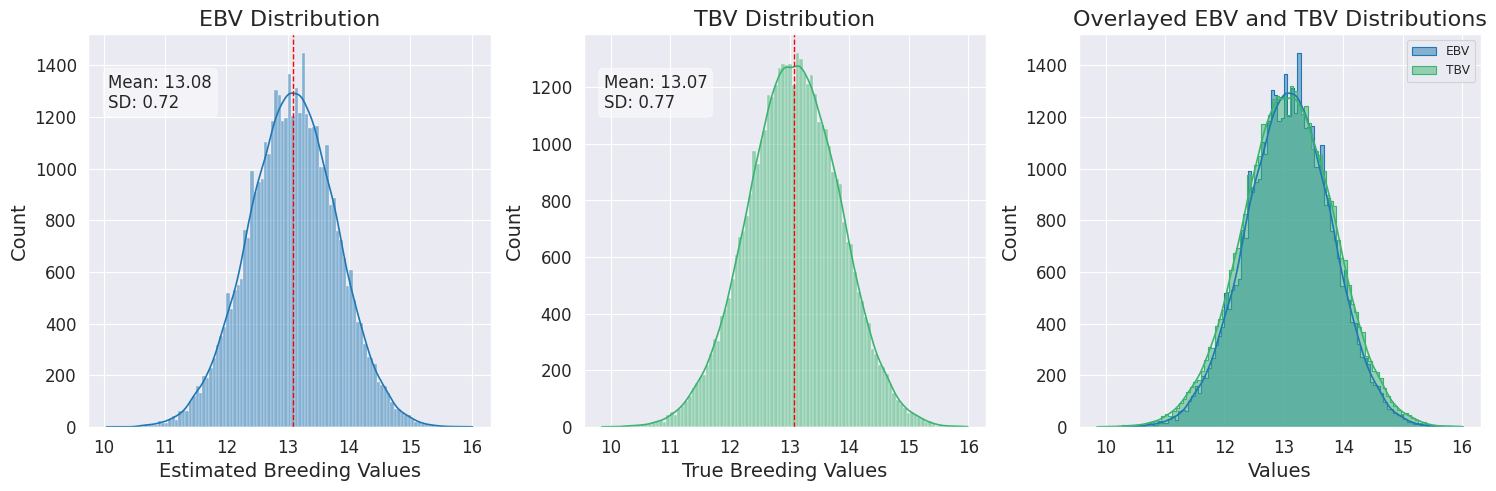

In [44]:
plot_histograms(output_np, targets_np, 'Hyena_r_lt')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


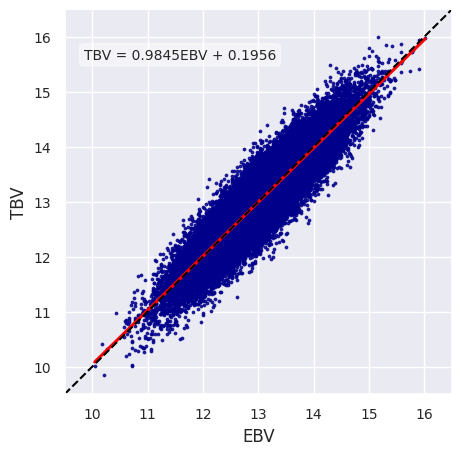

In [84]:
createScatterPlot(inference_df, 'Hyena_r_lt')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


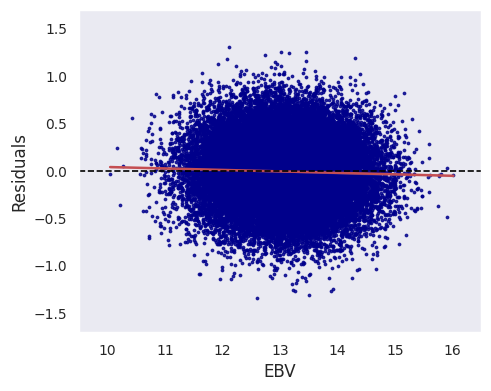

In [37]:
plot_residuals(output_np, targets_np, 'Hyena_r_lt')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


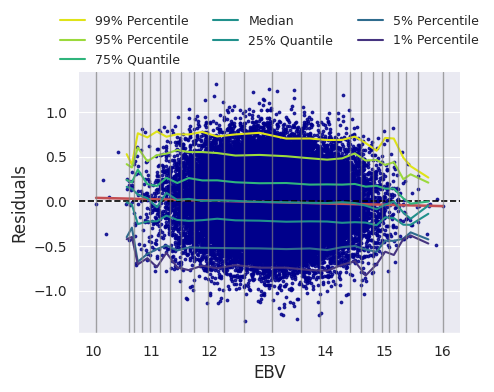

In [38]:
plot_wandering_schemantic(output_np, targets_np, 'Hyena_r_lt')

In [54]:
import scipy.stats
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    print(h)
    print(se)
    return m, m-h, m+h

In [55]:
a,b,c =  mean_confidence_interval(mae_errors)

5.912529485424772e-05
3.0129972803049753e-05


In [55]:
stratifiedMetrics(output_np, targets_np, 5)


Value Range for Bin 1: 9.853228569030762 - 11.0800350189209
Mean Absolute Error: 0.3899694216453423

Value Range for Bin 2: 11.0800350189209 - 12.306841468811035
Mean Absolute Error: 0.28560778318672736

Value Range for Bin 3: 12.306841468811035 - 13.533647918701172
Mean Absolute Error: 0.23728286666973644

Value Range for Bin 4: 13.533647918701172 - 14.760454368591308
Mean Absolute Error: 0.2560796674343638

Value Range for Bin 5: 14.760454368591308 - 15.987260818481445
Mean Absolute Error: 0.3339170594289513


In [72]:
calcMetrics(output_np, targets_np)

MSE: 0.09995907518736379
Mean Absolute Error: 0.2519048904464358
R2 Score: 0.8333227270294414
Pearson Correlation Coefficient: 0.9130195813383502
p-value: 0.0
rmse: 0.3161630515847223
mape: 1.937163356094538
mbe: -0.006761632260822115


### XAI

In [130]:
X_train_tensor = train_loader.dataset.tensors[0]
X_val_tensor = val_loader.dataset.tensors[0]
y_val_tensor = val_loader.dataset.tensors[1]
id_val_tensor = val_loader.dataset.tensors[2]

In [131]:
random_indices = torch.randperm(X_train_tensor.shape[0])[:100]
subset_X_train = X_train_tensor[random_indices]

In [133]:
# Define the number of desired samples
num_samples = 50

# Define the number of bins for the 'output' column
num_bins = 10

# Create bins and assign each row to a bin
model_data['output_bins'] = pd.cut(model_data['output'], bins=num_bins, labels=False)

# Stratified sampling
sampled_data = model_data.groupby('output_bins', group_keys=False).apply(lambda x: x.sample(int(num_samples/num_bins), random_state=42))
sampled_data.reset_index(drop=True, inplace=True)
sampled_data.drop(columns=['output_bins'], inplace=True)

In [134]:
sampled_data.shape

(50, 26285)

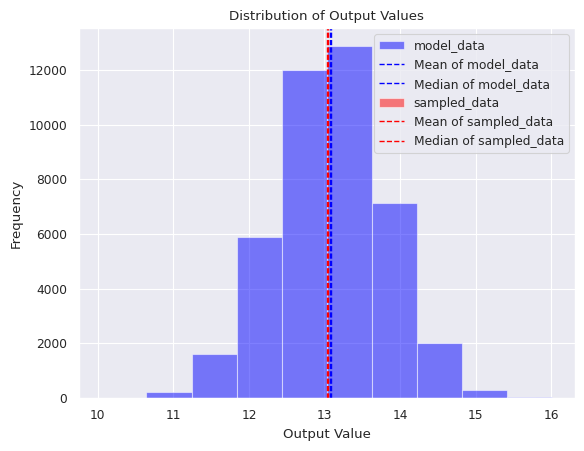

In [135]:
plt.hist(model_data['output'], bins=10, alpha=0.5, label='model_data', color='blue')
plt.axvline(model_data['output'].mean(), color='blue', linestyle='dashed', linewidth=1, label='Mean of model_data')
plt.axvline(model_data['output'].median(), color='blue', linestyle='dashed', linewidth=1, label='Median of model_data')

# Plotting the distribution of 'output' in sampled_data
plt.hist(sampled_data['output'], bins=10, alpha=0.5, label='sampled_data', color='red')
plt.axvline(sampled_data['output'].mean(), color='red', linestyle='dashed', linewidth=1, label='Mean of sampled_data')
plt.axvline(sampled_data['output'].median(), color='red', linestyle='dashed', linewidth=1, label='Median of sampled_data')

plt.xlabel('Output Value')
plt.ylabel('Frequency')
plt.title('Distribution of Output Values')

plt.legend()

In [137]:

selected_ids = sampled_data['id'].tolist()

selected_ids_set = set(selected_ids)

# Create a list to store the selected X_val_tensor values
selected_values = []
selected_ids = []
selected_targets = []

# Iterate through the IDs in id_val_tensor and check if they are in the selected_ids_set
for idx, id_val in enumerate(id_val_tensor):
    if id_val.item() in selected_ids_set:
        selected_values.append(X_val_tensor[idx])
        selected_ids.append(id_val_tensor[idx])
        selected_targets.append(y_val_tensor[idx])

# Convert selected_values list to a tensor
selected_values_tensor = torch.stack(selected_values)
selected_ids_tensor = torch.stack(selected_ids)
selected_targets_tensor = torch.stack(selected_targets)


In [138]:
selected_values_tensor

tensor([[1, 0, 0,  ..., 1, 0, 1],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 2, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32)

In [139]:
selected_ids_tensor

tensor([1262210, 1262784, 1263456, 1263863, 1263890, 1264908, 1265665, 1268530,
        1268601, 1269392, 1269718, 1271758, 1272200, 1273644, 1274766, 1275565,
        1276799, 1278205, 1278557, 1280834, 1281375, 1281652, 1281717, 1282330,
        1282790, 1283326, 1283451, 1283715, 1284264, 1285374, 1285515, 1286354,
        1287501, 1289383, 1289467, 1290254, 1292628, 1293192, 1293294, 1294469,
        1295009, 1295145, 1295913, 1297671, 1297689, 1299192, 1299209, 1299300,
        1300168, 1301768], dtype=torch.int32)

In [76]:
def evaluateShap2():
    inference_df = pd.DataFrame(columns=['targets', 'output'])
    dtype1 = torch.cuda.IntTensor
    dtype2 = torch.cuda.FloatTensor

    dfs = []

    with torch.no_grad():
        for data, targets, ids in val_loader:
            with torch.cuda.amp.autocast():
                data = data.to(device).type(dtype1)
                targets = targets.squeeze().to(device).type(dtype2)
                ids = ids.to(device).type(dtype1)

                output = wrapper_model(data.to(torch.float32))

                output = output.squeeze()
                
                targets_np = targets.cpu().numpy()
                output_np = output.cpu().numpy().astype('float32')
                ids_np = ids.cpu().numpy().astype('int')

                temp_df = pd.DataFrame({
                    'targets': targets_np,
                    'output': output_np,
                    'id': ids_np
                })

                inference_df = pd.concat([inference_df, temp_df], ignore_index=True)

    targets = torch.tensor(inference_df['targets'].values).to(device)
    output = torch.tensor(inference_df['output'].values).to(device)
    
    return inference_df, output, targets

In [48]:
import torch.nn as nn

class WrapperModel(nn.Module):
    def __init__(self, pretrained_model):
        super(WrapperModel, self).__init__()
        self.pretrained_model = pretrained_model

    def forward(self, x):
        output1, _, _ = self.pretrained_model(x)

        return output1
    
# Create the wrapper model
wrapper_model = WrapperModel(model)

class WrapperModel2(nn.Module):
    def __init__(self, pretrained_model):
        super(WrapperModel2, self).__init__()
        self.pretrained_model = pretrained_model

    def forward(self, x):
        output1, _, _ = self.pretrained_model(x.to(torch.int32))

        return output1


In [49]:
from captum.attr import (
    DeepLiftShap,
    LayerIntegratedGradients,
    DeepLiftShap
)

In [168]:
baseTensor = torch.randint(0, 3, size=selected_values_tensor.shape)

In [76]:
#baseTensor = torch.full(selected_values_tensor.shape, 4)

In [77]:
baseTensor

tensor([[1, 0, 2,  ..., 2, 0, 0],
        [0, 0, 1,  ..., 2, 1, 1],
        [1, 0, 2,  ..., 0, 2, 0],
        ...,
        [0, 0, 2,  ..., 2, 0, 0],
        [2, 2, 0,  ..., 1, 2, 2],
        [2, 0, 2,  ..., 0, 1, 2]])

In [52]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

In [52]:
#lig = LayerDeepLift(wrapper_model, wrapper_model.pretrained_model.encoder)
#attributions, delta = lig.attribute(inputs=selected_values_tensor.to(device),baselines = baseTensor.to(device), return_convergence_delta=True)

In [169]:
lig = LayerIntegratedGradients(wrapper_model, wrapper_model.pretrained_model.encoder)
attributions, delta = lig.attribute(inputs=selected_values_tensor.to(device),baselines = baseTensor.to(device), return_convergence_delta=True, n_steps = 80)

In [54]:
attributions.shape

torch.Size([50, 26282, 8])

In [67]:
delta

tensor([ 0.0161, -0.0045, -0.0186, -0.0060, -0.0144, -0.0060, -0.0374, -0.0281,
        -0.0241,  0.0194, -0.0343, -0.0065,  0.0010, -0.0246,  0.0317,  0.0103,
        -0.0080,  0.0042, -0.0162,  0.0125,  0.0425,  0.0050,  0.0026,  0.0426,
         0.0012, -0.0215, -0.0642, -0.0094, -0.0508,  0.0318, -0.0076,  0.0613,
        -0.0084,  0.0526,  0.0770,  0.0335, -0.0580, -0.0628, -0.0009,  0.0029,
         0.0299, -0.0050,  0.0297,  0.0395, -0.0182, -0.0086, -0.0095,  0.0075,
        -0.0107,  0.0032], dtype=torch.float64)

In [60]:
delta.mean()

tensor(0.0024, dtype=torch.float64)

In [159]:
delta_np = delta.cpu().numpy()

In [171]:
attributions_sum = summarize_attributions(attributions)

In [156]:
attributions_mean_all = attributions_sum.cpu().mean(0).detach().numpy()
attributions_all_norm = attributions_mean_all / np.linalg.norm(attributions_mean_all, ord=1)

In [172]:
attributions_sum_all = attributions_sum.abs().detach().numpy().sum(0)
attributions_all_norm = attributions_sum_all / np.linalg.norm(attributions_sum_all, ord=1)

In [153]:
attributions_sum_all.sum()

183.20164327498156

In [108]:
attributions_all_norm.sum()

0.9999999999999999

In [39]:
delta = np.load(dataRoot + heritability + eval_dataframes + 'LayerIntegratedGradients_delta.npy')
delta.mean()

0.0005441663517567807

In [40]:
attributions_all_norm = np.load(dataRoot + heritability + eval_dataframes + 'LayerIntegratedGradients_attributions_all_norm_v03_' + modelName + '.npy')
attributions_all_norm

array([1.94524385e-05, 1.05171497e-07, 5.01418744e-07, ...,
       2.45272466e-06, 7.04770502e-08, 2.98331971e-06])

In [41]:
attributions_sum = np.load(dataRoot + heritability + eval_dataframes + 'LayerIntegratedGradients_attributions_sum_v03_' + modelName + '.npy')
attributions_sum 

array([[ 9.87529385e-05,  8.64382886e-07,  0.00000000e+00, ...,
         6.40121322e-07,  3.16223675e-07,  0.00000000e+00],
       [ 0.00000000e+00,  8.12067581e-07,  3.56253654e-06, ...,
        -6.25157626e-06,  0.00000000e+00,  0.00000000e+00],
       [ 1.71507127e-04,  6.52103626e-07,  2.86077543e-06, ...,
         0.00000000e+00,  0.00000000e+00,  1.22003641e-05],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  2.51745403e-06, ...,
        -2.06549076e-05,  0.00000000e+00,  1.23839087e-05],
       [ 1.48952702e-04,  6.99949000e-07,  3.07067256e-06, ...,
         0.00000000e+00,  3.88372576e-07,  1.51053124e-05],
       [ 7.23064738e-05,  2.74923416e-07,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.70877195e-05]])

In [37]:
def scale_array(arr):
    max_val = np.max(np.abs(arr))
    scaled_arr = arr / max_val
    return scaled_arr

In [38]:
# Normalize 'eff' values
attributions_all_norm = abs(attributions_all_norm)
attr_min = attributions_all_norm.min()
attr_max = attributions_all_norm.max()
attributions_all_norm_scaled = (attributions_all_norm - attr_min) / (attr_max - attr_min)

In [41]:
attributions_all_norm_scaled = attributions_all_norm * 100

In [42]:
df_feature_importance = pd.DataFrame(attributions_all_norm_scaled)
df_feature_importance.rename(columns={0: 'importance'}, inplace=True)

df_test_maf = pd.read_parquet(dataRoot + heritability + testPath, engine='pyarrow')
df_test_maf.drop(columns=['phenotype', 'id'], inplace=True)
df_ped = pd.read_csv(pedigree_path, sep=" ", header=None, names=["id", "sire", "dam", "generation"])
df_snpPos = pd.read_csv(snpPos_path, sep=" ")
df_qtl = pd.read_csv(qtl_path, sep=" ")
df_qtl.drop(columns=['id'], inplace=True)

# Extract BPpos numbers from column names in df_test_maf
bp_pos_numbers = []

for column_name in df_test_maf.columns:
    if column_name.startswith('snp_'):
        bp_pos_number = int(column_name.split('_')[1])
        bp_pos_numbers.append(bp_pos_number)

df_feature_importance['id'] = bp_pos_numbers

df_featureImportance = pd.merge(df_snpPos, df_feature_importance, on='id', how='outer')
df_featureImportance = pd.merge(df_featureImportance, df_qtl, on=['site','chr','BPpos'], how='outer')

# Check if both 'importance' and 'eff' columns have NaN values
mask = df_featureImportance['importance'].isna() & df_featureImportance['eff'].isna()

# Set 'importance' to 0 where the condition is True
df_featureImportance.loc[mask, 'importance'] = 0

df_importance_All = df_featureImportance[['BPpos','chr','site', 'importance']].dropna()
df_eff_All = df_featureImportance[['BPpos','chr','site', 'eff']].dropna()



In [69]:
# Normalize 'eff' values to be between -1 and 1
df_eff_All['eff_normalized'] = scale_array(df_eff_All['eff'])

In [118]:
# Normalize 'eff' values to be between 0 and 1
df_eff_All['eff'] = abs(df_eff_All['eff'])
eff_min = df_eff_All['eff'].min()
eff_max = df_eff_All['eff'].max()
df_eff_All['eff_normalized'] = (df_eff_All['eff'] - eff_min) / (eff_max - eff_min)

In [51]:
#No scale
df_eff_All['eff_normalized'] = abs(df_eff_All['eff'])

In [120]:
df_eff_All['eff_normalized'].max()

1.0

In [47]:
df_importance_All_sorted = df_importance_All.sort_values(by='importance', ascending=False)
df_importance_All_sorted

,BPpos,chr,site,importance
19545,78551799,12,3299,0.650288
46670,11101944,29,480,0.483430
25425,29512050,16,1298,0.446943
19544,78500809,12,3298,0.437296
31693,8970225,20,386,0.430150
...,...,...,...,...
22542,58015370,14,2466,0.000000
22541,58011616,14,2465,0.000000
22539,57965722,14,2463,0.000000
22537,57930756,14,2460,0.000000


In [ ]:
sorted_df = df_eff_All[df_eff_All['chr'] == 12].sort_values(by='eff_normalized', ascending = False)

In [201]:
from matplotlib.ticker import MultipleLocator
def printImportanceScoresAbs(df_importance_All, df_eff_All, chromosoms, threshold):
    num_chromosomes = len(chromosoms)
    fig, axes = plt.subplots(num_chromosomes, 1, figsize=(10, 5*num_chromosomes))
    
    for i, chromosom in enumerate(chromosoms):
        df_importance = df_importance_All[df_importance_All['chr'] == chromosom]
        df_eff = df_eff_All[df_eff_All['chr'] == chromosom]

        ax = axes[i] if num_chromosomes > 1 else axes

        # Filter importance scores based on threshold
        significant_importance = df_importance[df_importance['importance'].abs() >= threshold]
        below_threshold_importance = df_importance[df_importance['importance'].abs() < threshold]
        
        ax.scatter(significant_importance['BPpos'], significant_importance['importance'].abs(), color='darkblue', label='Predicted Importance')
        ax.scatter(below_threshold_importance['BPpos'], below_threshold_importance['importance'].abs(), color='lightblue', alpha=0.5)

        for bp_pos, eff_value in zip(df_eff['BPpos'], df_eff['eff_normalized']):
            ax.vlines(bp_pos, ymin=0, ymax=significant_importance['importance'].abs().max(), color='green', alpha=abs(eff_value), linewidth=1)

        legend_labels = ['SNP Attribution > 0.05', 'SNP Attribution < 0.05','QTL']
        ax.legend(legend_labels)
        

        ax.set_xlabel(f'Chromosome {chromosom} BP Position', fontsize=12)
        ax.set_ylabel('SNP Attribution', fontsize=12)

        ax.set_title(f'SNP Attribution for Chromosome {chromosom}', fontsize=14)
        
        step_size = 0.1e8
        ax.xaxis.set_major_locator(MultipleLocator(step_size))
        #ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
        
        plt.tick_params(axis='both', which='major', labelsize=10)

        # Adjust figure layout
        plt.tight_layout()

        plt.savefig(f'images/chr_{chromosom}' + '.png')
        plt.savefig(f'images/chr_{chromosom}' + '.svg', format='svg', dpi=300)
        cairosvg.svg2pdf(url=f'images/chr_{chromosom}' + '.svg', write_to=f'images/chr_{chromosom}' + '.pdf')
        plt.savefig(f'images/chr_{chromosom}' + '.eps', format='eps')

    plt.tight_layout()
    plt.show()


In [85]:
from matplotlib.ticker import MultipleLocator
import matplotlib.cm as cm
from matplotlib.lines import Line2D

def printImportanceScoresAbsHeat(df_importance_All, df_eff_All, chromosoms, threshold):
    num_chromosomes = len(chromosoms)
    fig, axes = plt.subplots(num_chromosomes, 1, figsize=(8, 4*num_chromosomes))
    
    for i, chromosom in enumerate(chromosoms):
        df_importance = df_importance_All[df_importance_All['chr'] == chromosom]
        df_eff = df_eff_All[df_eff_All['chr'] == chromosom]

        ax = axes[i] if num_chromosomes > 1 else axes

        # Filter importance scores based on threshold
        significant_importance = df_importance[df_importance['importance'].abs() >= threshold]
        below_threshold_importance = df_importance[df_importance['importance'].abs() < threshold]
        
        # Create a colormap normalization
        norm = Normalize(vmin=df_eff_All['eff_normalized'].min(), vmax=df_eff_All['eff_normalized'].max()) 
        cmap = cm.OrRd  # Use 'jet' colormap, change as needed
        
        for bp_pos, eff_value in zip(df_eff['BPpos'], df_eff['eff_normalized']):
            color = cm.OrRd(eff_value)  # Choosing the colormap (coolwarm) based on eff_value #coolwarm #RdYlGn #YlGn #YlOrRd #viridis
            color = cmap(norm(eff_value))
            ax.vlines(bp_pos, ymin=0, ymax=significant_importance['importance'].abs().max(), color=color, linewidth=1)

        ax.scatter(significant_importance['BPpos'], significant_importance['importance'].abs(), color='darkblue', label='Predicted Importance', zorder=2)
        ax.scatter(below_threshold_importance['BPpos'], below_threshold_importance['importance'].abs(), color='lightblue', alpha=0.5, zorder=2)

        # Creating a color bar for the colormap
        scalarmappaple = cm.ScalarMappable(cmap=cmap, norm=norm)
        scalarmappaple.set_array(df_eff['eff_normalized'])
        cbar = plt.colorbar(scalarmappaple, ax=axes, orientation='vertical', label='QTL Effect', fraction=0.05)
        cbar.ax.tick_params(labelsize=14)
        cbar.set_label('QTL Effect', size=16)
        
        legend_labels = ['Attribution > 0.05%', 'Attribution < 0.05%', 'QTL']
        legend_handles = []
        
        scatter_sig = ax.scatter([], [], color='darkblue', label='Predicted Importance')
        scatter_below = ax.scatter([], [], color='lightblue', alpha=0.5)
        legend_handles.extend([scatter_sig, scatter_below])

        qtl_handle = Line2D([0], [0], color='darkred', linewidth=1)
        legend_handles.append(qtl_handle)

        ax.legend(loc='lower center', bbox_to_anchor=(0.49, 0.98), ncol=3, title=None, frameon=False, handles=legend_handles, labels=legend_labels , fontsize=12)

        ax.set_xlabel(f'Chromosome {chromosom} BP Position', fontsize=16)
        ax.set_ylabel('SNP Attribution [%]', fontsize=16)
        
        step_size = 0.1e8
        ax.xaxis.set_major_locator(MultipleLocator(step_size))
        
        plt.tick_params(axis='both', which='major', labelsize=14)
        ax.xaxis.get_offset_text().set_fontsize(12)  

        plt.tight_layout()

        plt.savefig(f'images/chr_{chromosom}' + '.png')
        plt.savefig(f'images/chr_{chromosom}' + '.svg', format='svg', dpi=300)
        cairosvg.svg2pdf(url=f'images/chr_{chromosom}' + '.svg', write_to=f'images/chr_{chromosom}' + '.pdf')
        plt.savefig(f'images/chr_{chromosom}' + '.eps', format='eps')

    plt.tight_layout()
    plt.show()


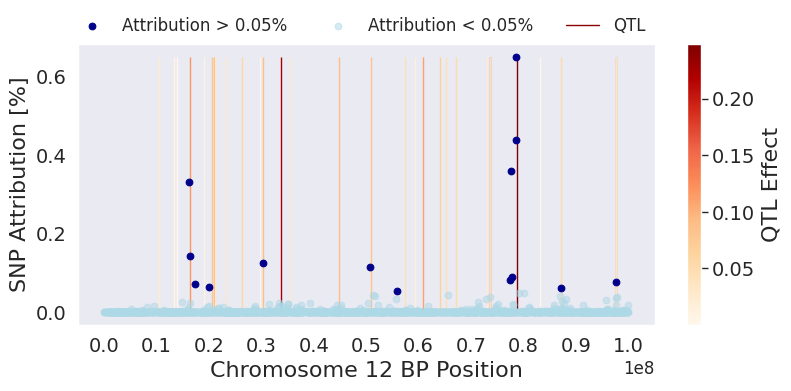

In [84]:
chromosomes_to_plot = [12] 
printImportanceScoresAbsHeat(df_importance_All, df_eff_All, chromosomes_to_plot, threshold)

In [188]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib import cm

def printImportanceScoresHeat(df_importance_All, df_eff_All, chromosoms, threshold):
    num_chromosomes = len(chromosoms)
    fig, axes = plt.subplots(num_chromosomes, 1, figsize=(10, 6*num_chromosomes))

    for i, chromosom in enumerate(chromosoms):
        df_importance = df_importance_All[df_importance_All['chr'] == chromosom]
        df_eff = df_eff_All[df_eff_All['chr'] == chromosom]

        ax = axes[i] if num_chromosomes > 1 else axes

        # Filter importance scores based on threshold
        significant_importance = df_importance[df_importance['importance'].abs() >= threshold]
        below_threshold_importance = df_importance[df_importance['importance'].abs() < threshold]

        ax.scatter(significant_importance['BPpos'], significant_importance['importance'], color='darkblue', label='Predicted Importance')
        ax.scatter(below_threshold_importance['BPpos'], below_threshold_importance['importance'], color='lightblue', alpha=0.5)
        
        # Create a colormap normalization
        norm = Normalize(vmin=0, vmax=1)  
        cmap = cm.jet 

        for bp_pos, eff_value in zip(df_eff['BPpos'], df_eff['eff_normalized']):
            color = cmap(norm(eff_value))
            if eff_value >= 0:
                ax.vlines(bp_pos, ymin=0, ymax=significant_importance['importance'].max(), color=color,linewidth=1)
            else:
                ax.vlines(bp_pos, ymin=-significant_importance['importance'].max(), ymax=0, color=color,  linewidth=1)

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
        cbar.set_label('Efficiency Value')

        ax.axhline(0, color='black', linewidth=1, linestyle='--')
                
        legend_labels = ['SNP Importance > 0.05%', 'SNP Importance < 0.05%','QTL']
        ax.legend(legend_labels)

        ax.set_xlabel('BPpos')
        ax.set_ylabel('Value')

        ax.set_title(f'Predicted SNP-Importance for Chromosome {chromosom}')

    plt.tight_layout()
    plt.show()

In [ ]:
threshold = 0.05

for chrNum in range(1, 31):
    chromosomes_to_plot = [chrNum]
    printImportanceScoresAbsHeat(df_importance_All, df_eff_All, chromosomes_to_plot, threshold)

In [48]:
# Concatenate DataFrames
concatenated = pd.concat([df_importance_All, df_eff_All])

# Sort by 'chr' and 'site'
sorted_concatenated = concatenated.sort_values(by=['chr', 'site'], ignore_index=True)

# Reset index
sorted_concatenated.reset_index(drop=True, inplace=True)


In [50]:
df_eff_All['id'] = df_eff_All['chr'].astype(str) + '_' + df_eff_All['site'].astype(str)

In [139]:
df_importance_All['id'] = df_importance_All['chr'].astype(str) + '_' + df_importance_All['site'].astype(str)

In [140]:
df_eff_All['importance'] = df_eff_All['eff_normalized']

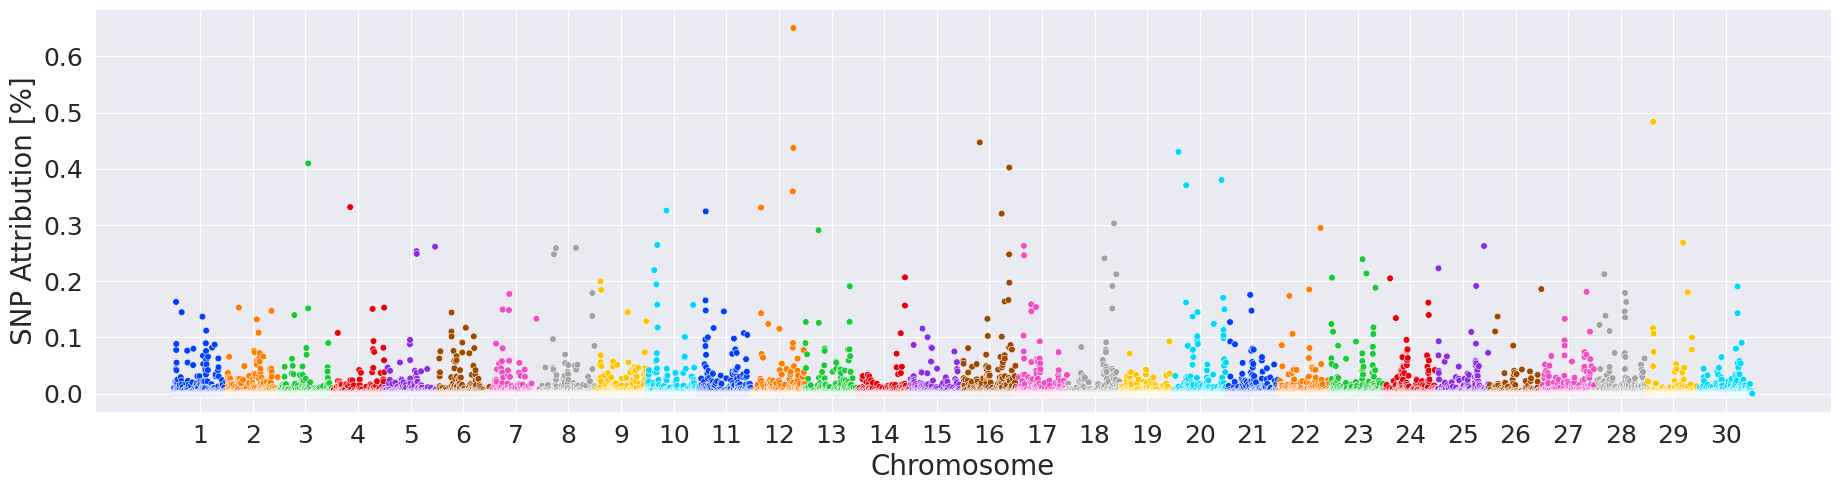

In [55]:
sns.set_style("darkgrid")

df_importance_All['id'] = range(0, len(df_importance_All))
plot = sns.relplot(data=df_importance_All, x='id', y='importance', aspect=3.7, 
                   hue='chr', palette = 'bright', legend=None, rasterized=True) 
chrom_df=df_importance_All.groupby('chr')['id'].median()
plot.ax.set_xlabel('Chromosome', fontsize=20)
plot.ax.set_ylabel('SNP Attribution [%]', fontsize=20)
plot.ax.set_xticks(chrom_df)
plot.ax.set_xticklabels(chrom_df.index)

plt.tick_params(axis='both', which='major', labelsize=18)
plt.tight_layout()

plt.savefig('images/manhattan' + '.png')
plt.savefig('images/manhattan' + '.svg', format='svg', dpi=300)
cairosvg.svg2pdf(url='images/manhattan' + '.svg', write_to='images/manhattan' + '.pdf')
plt.savefig('images/manhattan' + '.eps', format='eps')

/tmp/ipykernel_4185313/3546946029.py:17: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  plot = sns.relplot(data=df_importance_sorted, x=df_importance_sorted.index, y='importance', aspect=3.7,
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


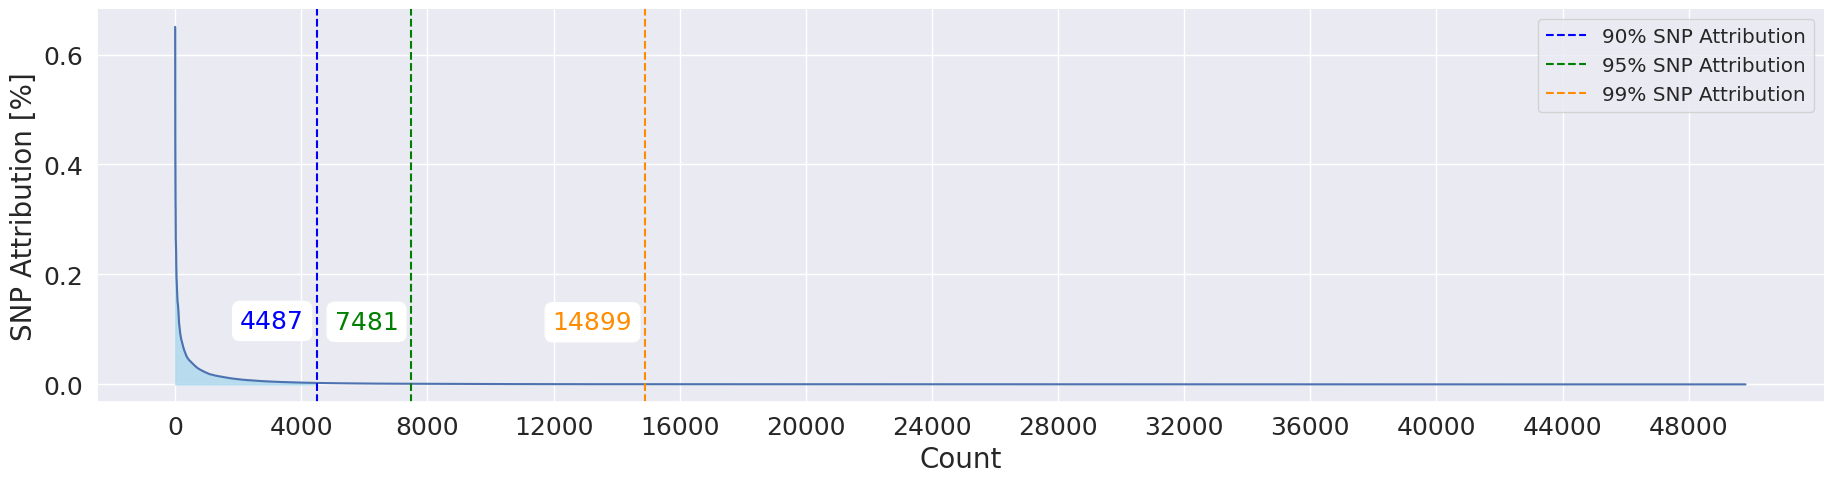

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df_importance_All['id'] = range(0, len(df_importance_All))

# Sort the DataFrame by 'importance'
df_importance_sorted = df_importance_All.sort_values(by='importance', ascending=False)

# Reindexing the DataFrame based on the sorted 'importance'
df_importance_sorted = df_importance_sorted.reset_index(drop=True)

sns.set(style="darkgrid")  

# Plotting importance values against reindexed 'id' based on 'importance' sorting
plot = sns.relplot(data=df_importance_sorted, x=df_importance_sorted.index, y='importance', aspect=3.7, 
                   palette='viridis', kind='line')

plot.set_axis_labels('Count', 'SNP Attribution [%]', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)

cumulative_sum = np.cumsum(df_importance_sorted['importance'])
index_90 = np.argmax(cumulative_sum >= 90)
index_95 = np.argmax(cumulative_sum >= 95)
index_99 = np.argmax(cumulative_sum >= 99)

plot.ax.fill_between(df_importance_sorted.index[:index_90 + 1], df_importance_sorted['importance'][:index_90 + 1], color='skyblue', alpha=0.5)

plot.ax.set_xticks(np.arange(0, len(df_importance_sorted), 4000))
plot.ax.set_xticklabels(np.arange(0, len(df_importance_sorted), 4000))

plot.ax.axvline(x=index_90, color='blue', linestyle='--', label=f'90% SNP Attribution')
plot.ax.axvline(x=index_95, color='green', linestyle='--', label=f'95% SNP Attribution')
plot.ax.axvline(x=index_99, color='darkorange', linestyle='--', label=f'99% SNP Attribution')
plot.ax.legend(fontsize='large') 

plot.ax.text(index_90 - 400, df_importance_sorted['importance'][index_90] + 0.1, f'{index_90}', color='blue', ha='right', bbox=dict(boxstyle='round', facecolor='white'), fontsize=18)
plot.ax.text(index_95 - 400, df_importance_sorted['importance'][index_95] + 0.1, f'{index_95}', color='green', ha='right', bbox=dict(boxstyle='round', facecolor='white'), fontsize=18)
plot.ax.text(index_99 - 400, df_importance_sorted['importance'][index_99] + 0.1, f'{index_99}', color='darkorange', ha='right', bbox=dict(boxstyle='round', facecolor='white'), fontsize=18)

plt.tight_layout()

plt.savefig('images/SNPSum' + '.png')
plt.savefig('images/SNPSum' + '.svg', format='svg', dpi=300)
cairosvg.svg2pdf(url='images/SNPSum' + '.svg', write_to='images/SNPSum' + '.pdf')
plt.savefig('images/SNPSum' + '.eps', format='eps')

plt.show()


## XGBoost

In [49]:
modelName = 'XGBoost'

In [50]:
eval_dataframes = '/eval_dataframes/xgboost/'
inference_df, output_np, targets_np, model_data = loadEvalData(modelName)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


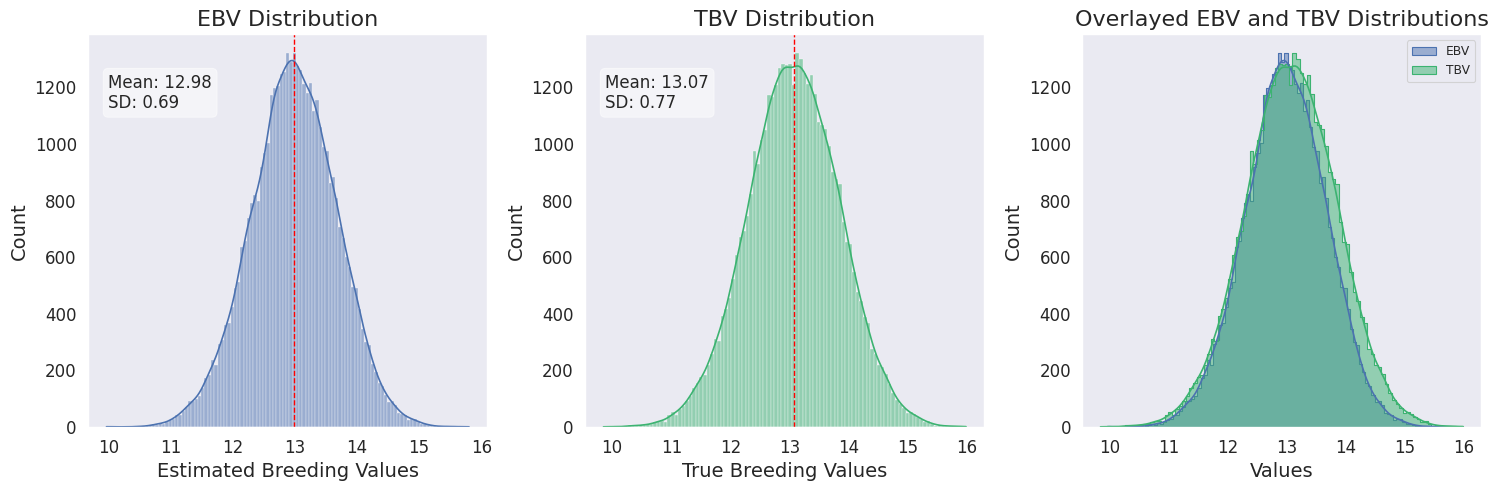

In [51]:
plot_histograms(output_np, targets_np, 'XGBoost')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


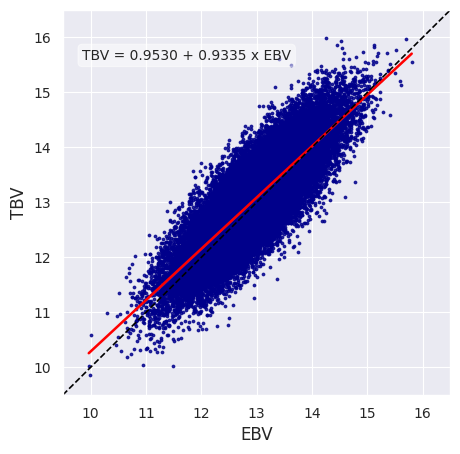

In [62]:
createScatterPlot(inference_df, 'XGBoost')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


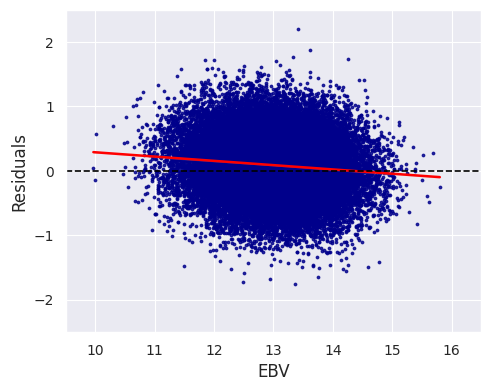

In [72]:
plot_residuals(output_np, targets_np, 'XGBoost')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


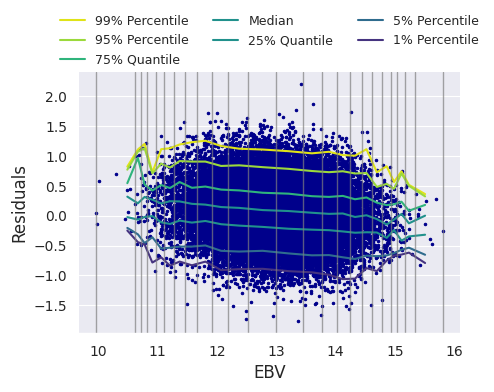

In [52]:
plot_wandering_schemantic(output_np, targets_np, 'XGBoost')

In [37]:
calcMetrics(output_np, targets_np)

MSE: 0.19626294172916872
Mean Absolute Error: 0.35288433197566443
R2 Score: 0.6727403504756233
Pearson Correlation Coefficient: 0.8305170870161966
p-value: 0.0
rmse: 0.4430157353065111
mape: 2.696649441200203
mbe: 0.09005237143380301


### MLM

In [73]:
eval_dataframes = '/eval_dataframes/mlm/'

In [74]:
df_mlmLoss = pd.read_csv(dataRoot + heritability + eval_dataframes + 'loss.csv', sep=",")
df_mlmAcc = pd.read_csv(dataRoot + heritability + eval_dataframes + 'accuracy.csv', sep=",")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


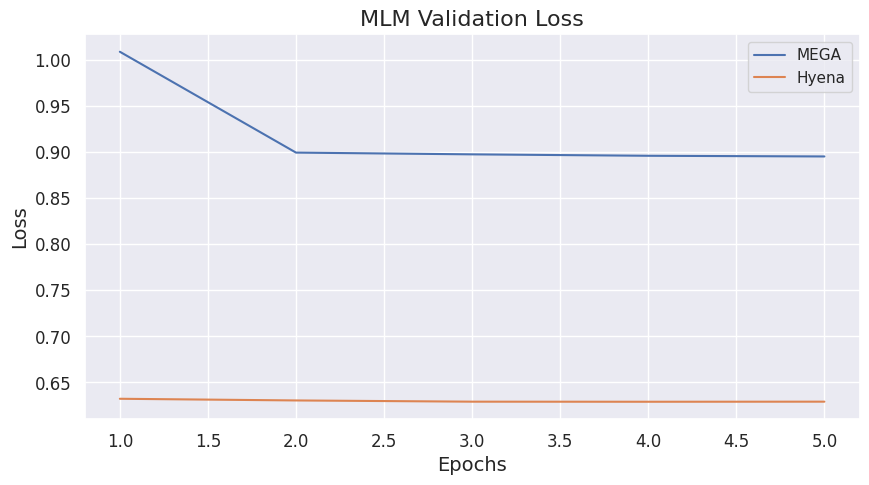

In [77]:
epochs = df_mlmLoss['train/epoch'].head(5).tolist()
loss_values_1 = df_mlmLoss['Hyena_MLM_v13_fine_L7_maf_dim8 - eval/loss'].head(5).tolist()
loss_values_2 = df_mlmLoss['MegaChunk_MLM_v12_gen30Fine - eval/loss'].head(5).tolist()

epochs = range(1, len(loss_values_1) + 1)

# Plotting the loss curves
plt.figure(figsize=(10,5))
sns.set(style="darkgrid")  

plt.plot(epochs, loss_values_2,  linestyle='-', label='MEGA')  # Second loss curve
plt.plot(epochs, loss_values_1, linestyle='-', label='Hyena')

plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('MLM Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend() 

plt.savefig('images/mlm_loss' + '.png')
plt.savefig('images/mlm_loss' + '.svg', format='svg', dpi=300)
cairosvg.svg2pdf(url='images/mlm_loss' + '.svg', write_to='images/mlm_loss' + '.pdf')
plt.savefig('images/mlm_loss' + '.eps', format='eps')

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


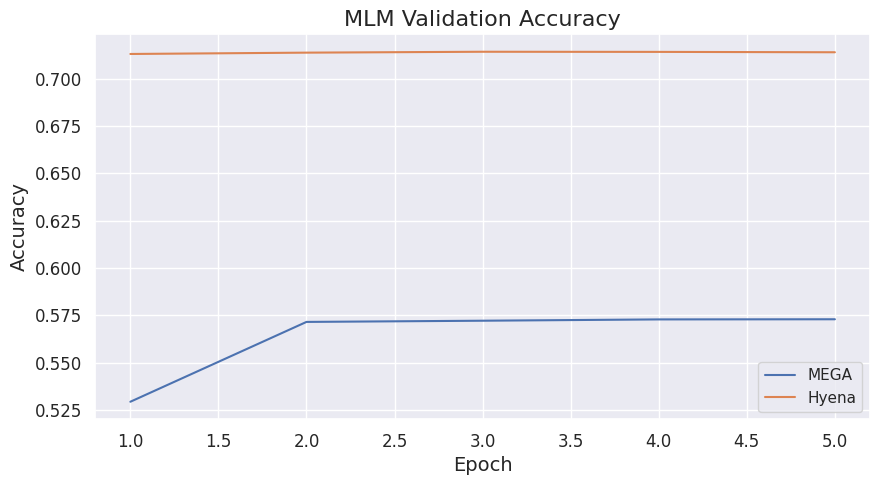

In [78]:
epochs = df_mlmAcc['train/epoch'].head(5).tolist()
loss_values_1 = df_mlmAcc['Hyena_MLM_v13_fine_L7_maf_dim8 - eval/accuracy'].head(5).tolist()
loss_values_2 = df_mlmAcc['MegaChunk_MLM_v12_gen30Fine - eval/accuracy'].head(5).tolist()

epochs = range(1, len(loss_values_1) + 1)

# Plotting the loss curves
plt.figure(figsize=(10, 5))
sns.set(style="darkgrid") 

plt.plot(epochs, loss_values_2,  linestyle='-', label='MEGA')  # Second loss curve
plt.plot(epochs, loss_values_1, linestyle='-', label='Hyena')

plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('MLM Validation Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend() 

plt.savefig('images/mlm_acc' + '.png')
plt.savefig('images/mlm_acc' + '.svg', format='svg', dpi=300)
cairosvg.svg2pdf(url='images/mlm_acc' + '.svg', write_to='images/mlm_acc' + '.pdf')
plt.savefig('images/mlm_acc' + '.eps', format='eps')

plt.show()